# IBM Developer Skills Network

# Logistic Regression With Mini-Batch Gradient Descent

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import torch # pytorch library
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn # pytorch neural network

In [2]:
# Create class for plotting and the function for plotting

class plot_error_surfaces(object):
    
    # Construstor
    def __init__(self, w_range, b_range, X, Y, n_samples = 30, go = True):
        W = np.linspace(-w_range, w_range, n_samples)  # n point from -wrange to +wrange
        B = np.linspace(-b_range, b_range, n_samples)
        w, b = np.meshgrid(W, B)    # create a rectangular grid in XY plane with W point in X and b point in y
        Z = np.zeros((30, 30)) # zeros matrix of size 30x30
        count1 = 0
        self.y = Y.numpy()  # convert pytorch tensor to numpy array
        self.x = X.numpy()
        for w1, b1 in zip(w, b): # combine each w element with a corresponding b element to form a tuple (wi,bi)
            count2 = 0
            for w2, b2 in zip(w1, b1):
                yhat= 1 / (1 + np.exp(-1*(w2*self.x+b2)))
                Z[count1,count2]=-1*np.mean(self.y*np.log(yhat+1e-16) +(1-self.y)*np.log(1-yhat+1e-16))
                count2 += 1   
            count1 += 1
        self.Z = Z
        self.w = w
        self.b = b
        self.W = []
        self.B = []
        self.LOSS = []
        self.n = 0
        if go == True:
            plt.figure()
            plt.figure(figsize=(7.5, 5))
            plt.axes(projection='3d').plot_surface(self.w, self.b, self.Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
            plt.title('Loss Surface')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.show()
            plt.figure()
            plt.title('Loss Surface Contour')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.contour(self.w, self.b, self.Z)
            plt.show()
            
     # Setter
    def set_para_loss(self, model, loss):
        self.n = self.n + 1
        self.W.append(list(model.parameters())[0].item())
        self.B.append(list(model.parameters())[1].item())
        self.LOSS.append(loss)
    
    # Plot diagram
    def final_plot(self): 
        ax = plt.axes(projection='3d')
        ax.plot_wireframe(self.w, self.b, self.Z)
        ax.scatter(self.W, self.B, self.LOSS, c='r', marker='x', s=200, alpha=1)
        plt.figure()
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c='r', marker='x')
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()
        
    # Plot diagram
    def plot_ps(self):
        plt.subplot(121)
        plt.ylim
        plt.plot(self.x[self.y==0], self.y[self.y==0], 'ro', label="training points")
        plt.plot(self.x[self.y==1], self.y[self.y==1]-1, 'o', label="training points")
        plt.plot(self.x, self.W[-1] * self.x + self.B[-1], label="estimated line")
        plt.xlabel('x')
        plt.ylabel('y')
        plt.ylim((-0.1, 2))
        plt.title('Data Space Iteration: ' + str(self.n))
        plt.show()
        plt.subplot(122)
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c='r', marker='x')
        plt.title('Loss Surface Contour Iteration' + str(self.n))
        plt.xlabel('w')
        plt.ylabel('b')
        
# Plot the diagram

def PlotStuff(X, Y, model, epoch, leg=True):
    
    plt.plot(X.numpy(), model(X).detach().numpy(), label=('epoch ' + str(epoch)))
    plt.plot(X.numpy(), Y.numpy(), 'r')
    if leg == True:
        plt.legend()
    else:
        pass

In [3]:
# Set the random seed
torch.manual_seed(0)

# Load Data

In [4]:
# Create the custom Data class which inherits Dataset
class Data(Dataset):
    
    # Constructor
    def __init__(self):
        # Create X values from -1 to 1 with step .1
        self.x = torch.arange(-1, 1, 0.1).view(-1, 1)
        # Create Y values all set to 0
        self.y = torch.zeros(self.x.shape[0], 1)
        # Set the X values above 0.2 to 1
        self.y[self.x[:, 0] > 0.2] = 1
        # Set the .len attribute because we need to override the __len__ method
        self.len = self.x.shape[0]
    
    # Getter that returns the data at the given index
    def __getitem__(self, index):      
        return self.x[index], self.y[index]
    
    # Get length of the dataset
    def __len__(self):
        return self.len

In [5]:
# Make Data object
data_set = Data()

In [6]:
data_set.x

tensor([[-1.0000e+00],
        [-9.0000e-01],
        [-8.0000e-01],
        [-7.0000e-01],
        [-6.0000e-01],
        [-5.0000e-01],
        [-4.0000e-01],
        [-3.0000e-01],
        [-2.0000e-01],
        [-1.0000e-01],
        [-2.9802e-09],
        [ 1.0000e-01],
        [ 2.0000e-01],
        [ 3.0000e-01],
        [ 4.0000e-01],
        [ 5.0000e-01],
        [ 6.0000e-01],
        [ 7.0000e-01],
        [ 8.0000e-01],
        [ 9.0000e-01]])

In [7]:
data_set.y

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [8]:
len(data_set)

20

In [9]:
# Get 1st x and y label data
x, y = data_set[0]  
print("x = {},  y = {}".format(x,y))

x = tensor([-1.]),  y = tensor([0.])


In [10]:
# Get 2nd x and y label data
x, y = data_set[1]  
print("x = {},  y = {}".format(x,y))

x = tensor([-0.9000]),  y = tensor([0.])


# Create the Model and Total Loss Function (Cost)

For Logistic Regression typically we would not use PyTorch instead we would use Scikit-Learn as it is easier to use and set up. We are using PyTorch because it is good practice for deep learning. Scikit-Learn is typically used for Machine Learning while PyTorch is used for Deep Learning.

In [11]:
# Create logistic_regression class that inherits nn.Module which is the base class for all neural networks
class logistic_regression(nn.Module):
    
    # Constructor
    def __init__(self, n_inputs):
        super(logistic_regression, self).__init__()
        # Single layer of Logistic Regression with number of inputs being n_inputs and there being 1 output 
        self.linear = nn.Linear(n_inputs, 1)
        
    # Prediction
    def forward(self, x):
        # Using the input x value puts it through the single layer defined above then puts the output through the sigmoid function and returns the result
        yhat = torch.sigmoid(self.linear(x))
        return yhat

In [12]:
# check the number of features an X value has, the size of the input
x, y = data_set[0]
len(x)

1

In [13]:
# Create a logistic regression object, input parameter is the number of dimensions
model = logistic_regression(1)

In [14]:
# Make a prediction 
x = torch.tensor([-1.0])

sigma = model(x)
sigma

tensor([0.6327], grad_fn=<SigmoidBackward>)

In [15]:
# Make a prediction using our dataset
x, y = data_set[2]

sigma = model(x)
sigma

tensor([0.6324], grad_fn=<SigmoidBackward>)

<Figure size 432x288 with 0 Axes>

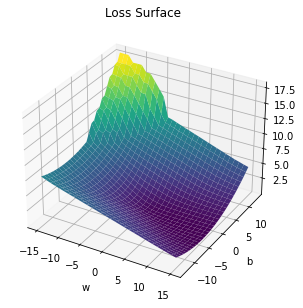

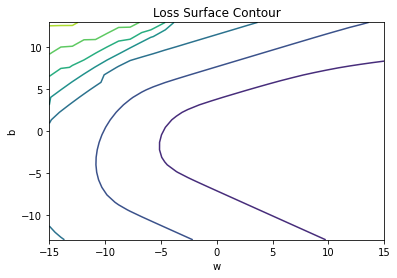

In [16]:
# Create a plot_error_surfaces object to visualize the data space and the learnable parameters space during training
# 15 is the range of w
# 13 is the range of b
# data_set[:][0] are all the X values
# data_set[:][1] are all the Y values

get_surface = plot_error_surfaces(15, 13, data_set[:][0], data_set[:][1])

In [17]:
# We define a criterion using Binary Cross Entropy Loss. This will measure the difference/loss between the prediction and actual value.
criterion = nn.BCELoss()

In [18]:
x, y = data_set[0]
print("x = {},  y = {}".format(x,y))

x = tensor([-1.]),  y = tensor([0.])


In [19]:
# predict the value
sigma = model(x)
sigma

tensor([0.6327], grad_fn=<SigmoidBackward>)

In [20]:
# Calculate the loss
loss = criterion(sigma, y)
loss

tensor(1.0016, grad_fn=<BinaryCrossEntropyBackward>)

# Setting the batch size using a Data Loader

In [22]:
batch_size = 10
trainloader = DataLoader(dataset=data_set, batch_size=10)
dataset_iter = iter(trainloader)
X,y = next(dataset_iter)
X  # 10 values

tensor([[-1.0000],
        [-0.9000],
        [-0.8000],
        [-0.7000],
        [-0.6000],
        [-0.5000],
        [-0.4000],
        [-0.3000],
        [-0.2000],
        [-0.1000]])

# Setting the Learning Rate

We can set the learning rate by setting it as a parameter in the optimizer along with the parameters of the logistic regression model we are training. The job of the optimizer, torch.optim.SGD, is to use the loss generated by the criterion to update the model parameters according to the learning rate. SGD stands for Stochastic Gradient Descent which typically means that the batch size is set to 1, but the data loader we set up above has turned this into Mini-Batch Gradient Descent.

In [23]:
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# Train the Model via Mini-Batch Gradient Descent

<Figure size 432x288 with 0 Axes>

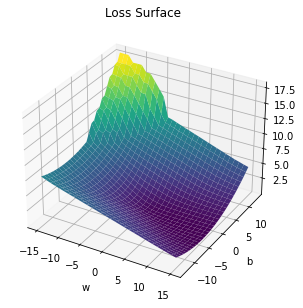

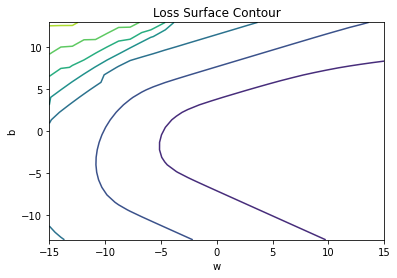

In [24]:
# we will set the batch size of the data loader to 5 and the number of epochs to 250
# First, we must recreate the get_surface object again so that for each example we get a Loss Surface for that model only.
get_surface = plot_error_surfaces(15, 13, data_set[:][0], data_set[:][1], 30)

## Train the Model

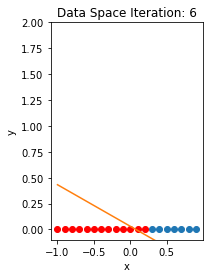

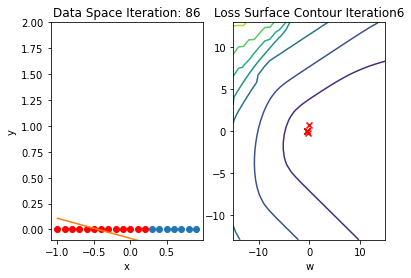

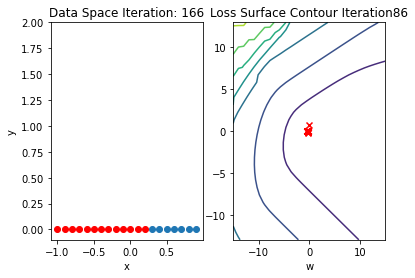

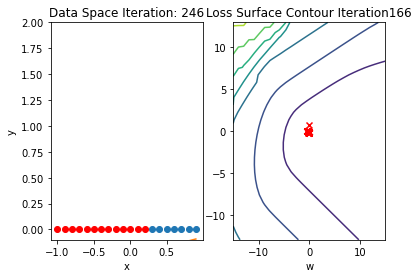

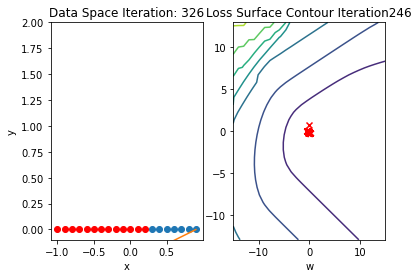

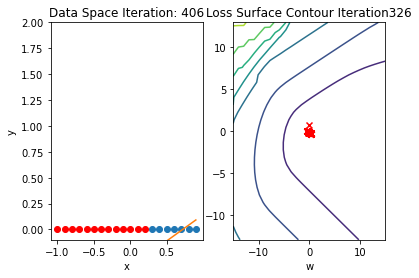

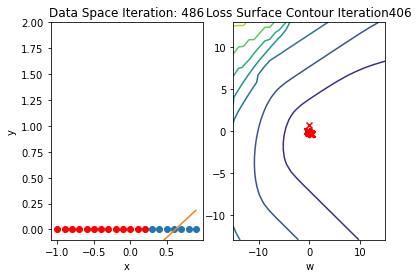

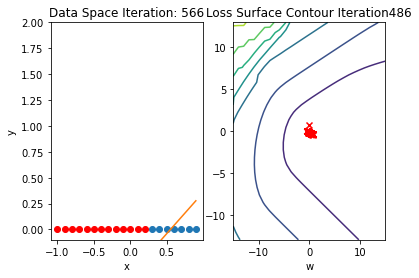

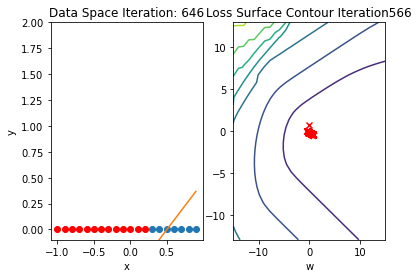

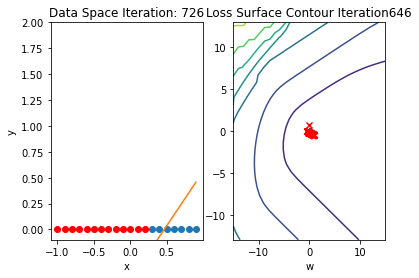

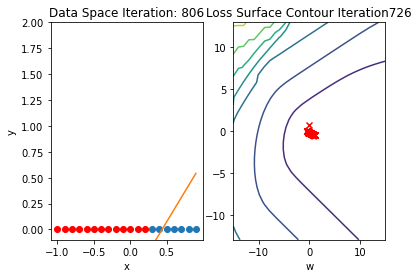

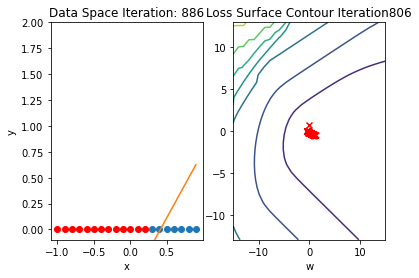

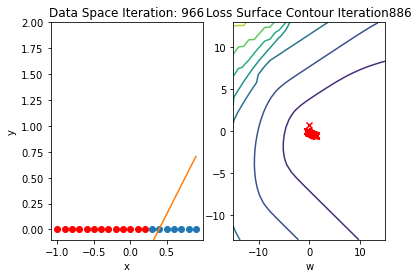

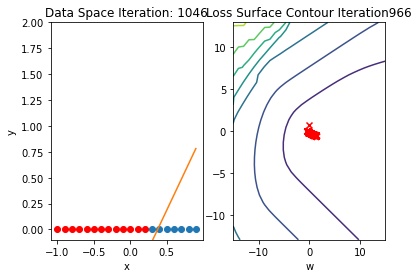

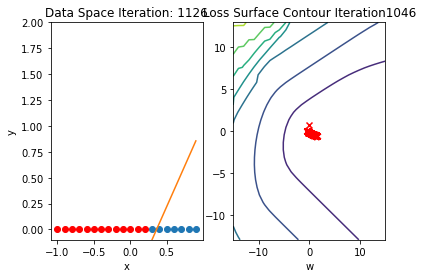

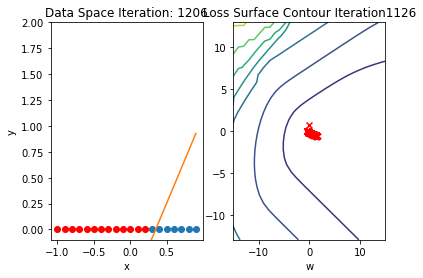

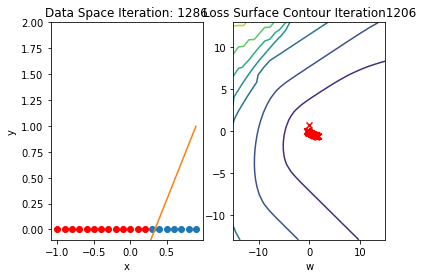

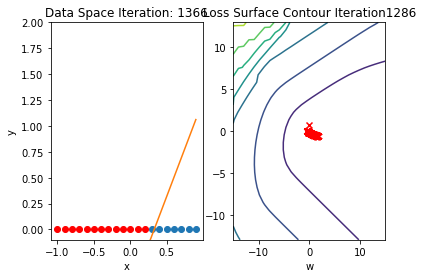

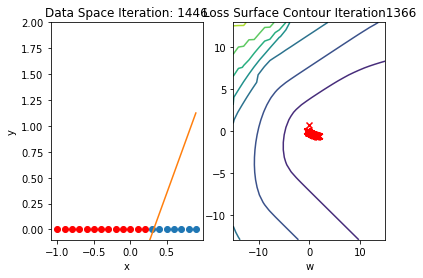

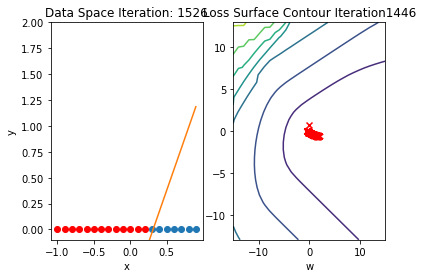

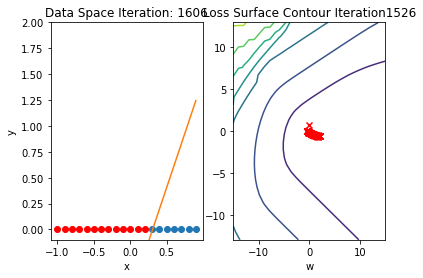

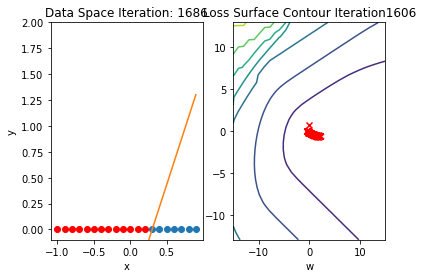

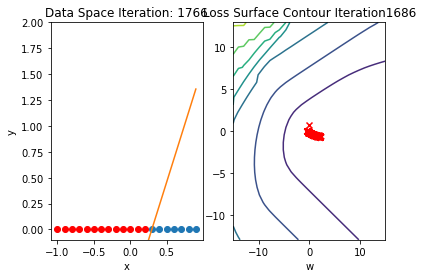

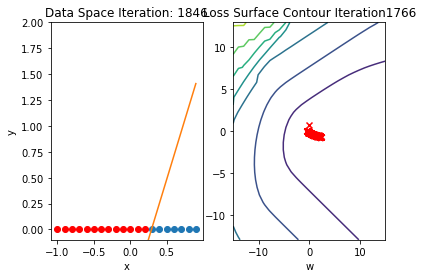

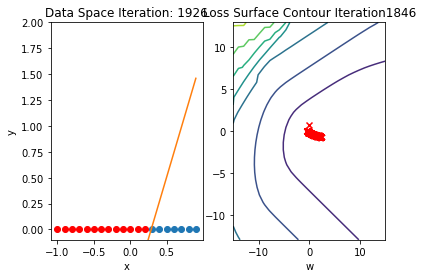

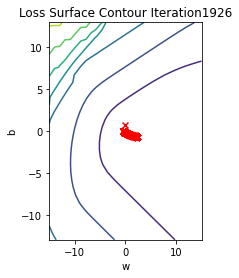

In [27]:
# Create an instance of the model
model = logistic_regression(1)

# create loss criterion
criterion = nn.BCELoss()

# creat a dataloader with size of 5
trainloader = DataLoader(dataset=data_set, batch_size=5)

# create an optimizer with the model parameters and learning rate
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

epochs = 500
loss_values = []

for epoch in range(epochs):
    # for each batch in trainning data
    for x, y in trainloader:
        # make predictions from X value
        yhat = model(x)
        
        # mesure the loss
        loss = criterion(yhat, y)

        # reset the calculated gradient value
        optimizer.zero_grad()

        # calculate the gradient value with respect to each weight and bias
        loss.backward()

        # updates the weight and bias according to calculated gradient value
        optimizer.step()

        # set parameters for loss surface contour
        get_surface.set_para_loss(model, loss.tolist())

        # save the loss of the iteration
        loss_values.append(loss)
    
    # print data space every 20 epochs
    if epoch % 20 == 0:
        get_surface.plot_ps()

We can see the final values of the weight and bias. This weight and bias correspond to the orange line in the Data Space graph and the final spot of the X in the Loss Surface Contour graph.

In [29]:
w = model.state_dict()['linear.weight'].data[0]
b = model.state_dict()['linear.bias'].data[0]
print("w = ", w, "b = ", b)

w =  tensor([2.4418]) b =  tensor(-0.6912)


In [30]:
# Get the accuracy of the training data
# predict
yhat = model(data_set.x)

# round the prediction to nearest 0 or 1
yhat = torch.round(yhat)

# Counter to keep track of correct prediction
correct = 0

for prediction, actual in zip(yhat, data_set.y):
    if (prediction == actual):
        correct+=1

print("Accuracy: ", correct/len(data_set)*100, "%")

Accuracy:  100.0 %


In [36]:
loss_values_conv = []

for loss_v in loss_values:
    loss_values_conv.append(loss_v.detach().numpy())

Text(0, 0.5, 'Cost')

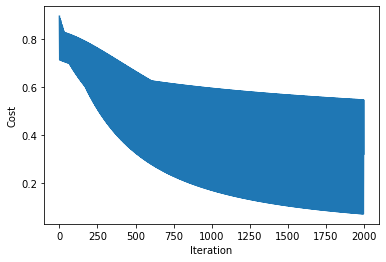

In [37]:
# Plot the Cost Vs Iteration graph
plt.plot(loss_values_conv)
plt.xlabel("Iteration")
plt.ylabel("Cost")

# Stochastic Gradient Descent

in this case, we will set the batch size of the data loder to 1 so that the gradient descent will be performed for each example this is referred to as Stochastic Gradient Descent. The number of epochs is set to 100.

<Figure size 432x288 with 0 Axes>

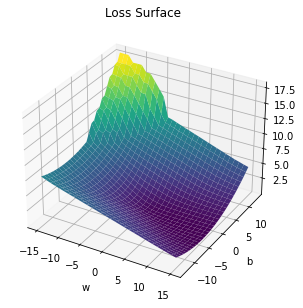

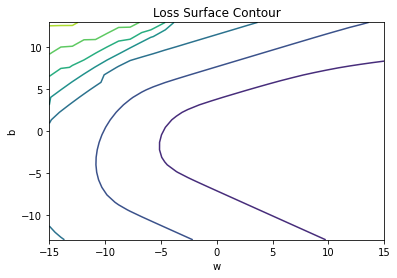

In [38]:
get_surface = plot_error_surfaces(15, 13, data_set[:][0], data_set[:][1], 30)

## Train the model

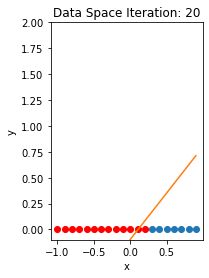

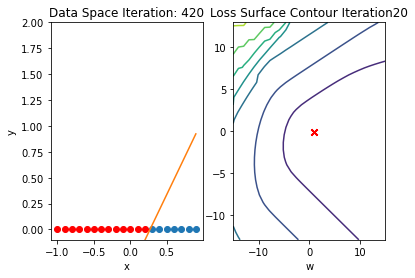

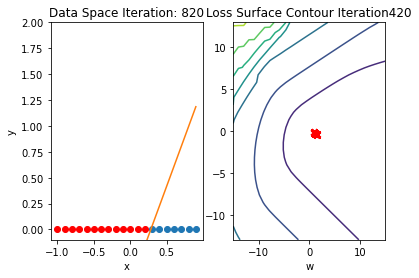

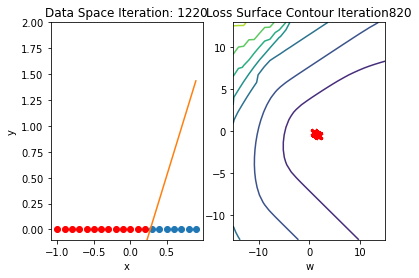

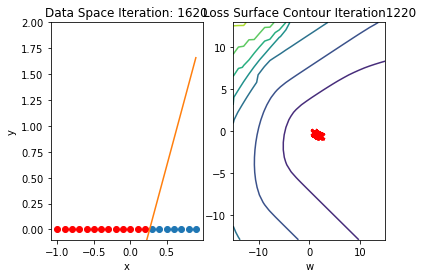

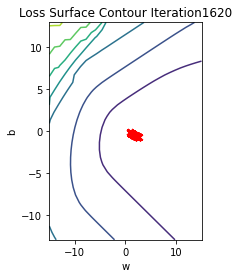

In [39]:
# First we create an instance of the model we want to train
model = logistic_regression(1)
# We create a criterion which will measure loss
criterion = nn.BCELoss()
# We create a data loader with the dataset and specified batch size of 1
trainloader = DataLoader(dataset = data_set, batch_size = 1)
# We create an optimizer with the model parameters and learning rate
optimizer = torch.optim.SGD(model.parameters(), lr = .01)
# Then we set the number of epochs which is the total number of times we will train on the entire training dataset
epochs=100
# This will store the loss over iterations so we can plot it at the end
loss_values = []

# Loop will execute for number of epochs
for epoch in range(epochs):
    # For each batch in the training data
    for x, y in trainloader:
        # Make our predictions from the X values
        yhat = model(x)
        # Measure the loss between our prediction and actual Y values
        loss = criterion(yhat, y)
        # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
        optimizer.zero_grad()
        # Calculates the gradient value with respect to each weight and bias
        loss.backward()
        # Updates the weight and bias according to calculated gradient value
        optimizer.step()
        # Set the parameters for the loss surface contour graphs
        get_surface.set_para_loss(model, loss.tolist())
        # Saves the loss of the iteration
        loss_values.append(loss)
    # Want to print the Data Space for the current iteration every 20 epochs
    if epoch % 20 == 0:
        get_surface.plot_ps()

In [40]:
# Final values of weight and bias
w = model.state_dict()['linear.weight'].data[0]
b = model.state_dict()['linear.bias'].data[0]
print("w = ", w, "b = ", b)

w =  tensor([2.8783]) b =  tensor(-0.7432)


In [41]:
# Getting the predictions
yhat = model(data_set.x)
# Rounding the prediction to the nearedt integer 0 or 1 representing the classes
yhat = torch.round(yhat)
# Counter to keep track of correct predictions
correct = 0
# Goes through each prediction and actual y value
for prediction, actual in zip(yhat, data_set.y):
    # Compares if the prediction and actualy y value are the same
    if (prediction == actual):
        # Adds to counter if prediction is correct
        correct+=1
# Outputs the accuracy by dividing the correct predictions by the length of the dataset
print("Accuracy: ", correct/len(data_set)*100, "%")

Accuracy:  100.0 %


In [42]:
loss_values_conv = []

for loss_v in loss_values:
    loss_values_conv.append(loss_v.detach().numpy())

Text(0, 0.5, 'Cost')

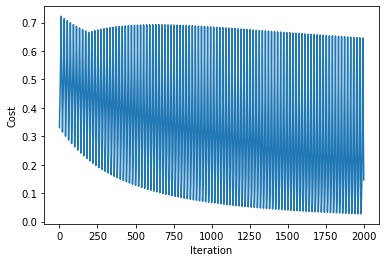

In [45]:
plt.plot(loss_values_conv)
plt.xlabel("Iteration")
plt.ylabel("Cost")

## High Learning Rate

In this case, we will set the batch size of the data loder to 1 so that the gradient descent will be performed for each example this is referred to as Stochastic Gradient Descent. This time the learning rate will be set to .1 to represent a high learning rate and we will observe what will happen when we try to train.

<Figure size 432x288 with 0 Axes>

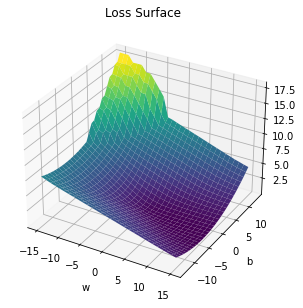

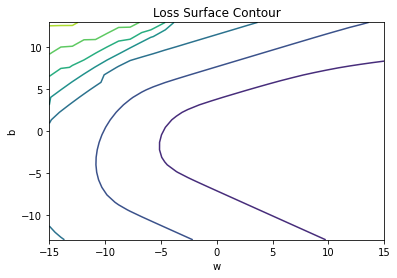

In [46]:
get_surface = plot_error_surfaces(15, 13, data_set[:][0], data_set[:][1], 30)

## Train the model

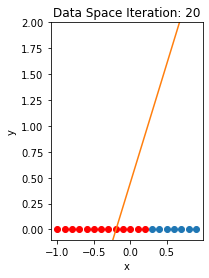

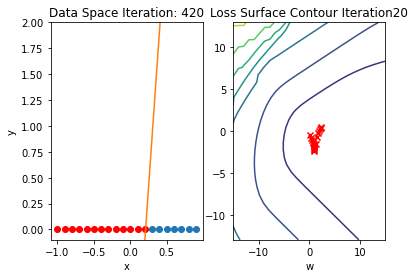

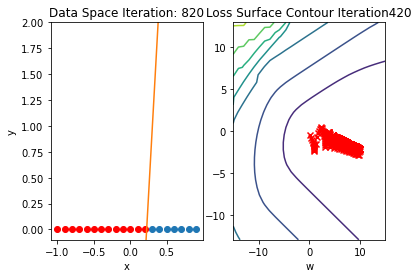

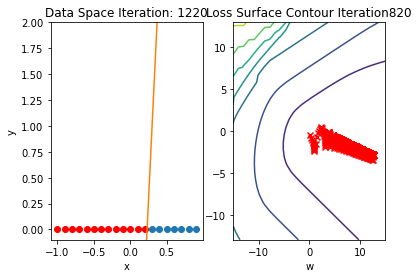

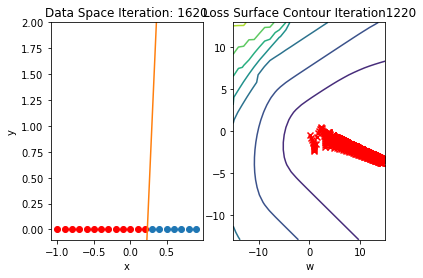

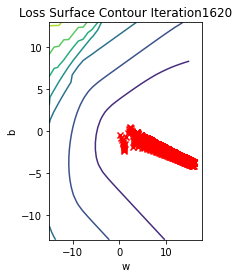

In [47]:
# First we create an instance of the model we want to train
model = logistic_regression(1)
# We create a criterion that will measure loss
criterion = nn.BCELoss()
# We create a data loader with the dataset and specified batch size of 1
trainloader = DataLoader(dataset = data_set, batch_size = 1)
# We create an optimizer with the model parameters and learning rate
optimizer = torch.optim.SGD(model.parameters(), lr = 1)
# Then we set the number of epochs which is the total number of times we will train on the entire training dataset
epochs=100
# This will store the loss over iterations so we can plot it at the end
loss_values = []

# Loop will execute for number of epochs
for epoch in range(epochs):
    # For each batch in the training data
    for x, y in trainloader:
        # Make our predictions from the X values
        yhat = model(x)
        # Measure the loss between our prediction and actual Y values
        loss = criterion(yhat, y)
        # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
        optimizer.zero_grad()
        # Calculates the gradient value with respect to each weight and bias
        loss.backward()
        # Updates the weight and bias according to calculated gradient value
        optimizer.step()
        # Set the parameters for the loss surface contour graphs
        get_surface.set_para_loss(model, loss.tolist())
        # Saves the loss of the iteration
        loss_values.append(loss)
    # Want to print the Data Space for the current iteration every 20 epochs
    if epoch % 20 == 0:
        get_surface.plot_ps()

Notice in this example the due to the high learning rate the Loss Surface Contour graph has increased movement over the previous example and also moves in multiple directions due to the minimum being overshot.

In [48]:
# final value of weight and bias
w = model.state_dict()['linear.weight'].data[0]
b = model.state_dict()['linear.bias'].data[0]
print("w = ", w, "b = ", b)

w =  tensor([17.3000]) b =  tensor(-4.0846)


In [49]:
# Getting the predictions
yhat = model(data_set.x)
# Rounding the prediction to the nearedt integer 0 or 1 representing the classes
yhat = torch.round(yhat)
# Counter to keep track of correct predictions
correct = 0
# Goes through each prediction and actual y value
for prediction, actual in zip(yhat, data_set.y):
    # Compares if the prediction and actualy y value are the same
    if (prediction == actual):
        # Adds to counter if prediction is correct
        correct+=1
# Outputs the accuracy by dividing the correct predictions by the length of the dataset
print("Accuracy: ", correct/len(data_set)*100, "%")

Accuracy:  100.0 %


In [50]:
loss_values_conv = []

for loss_v in loss_values:
    loss_values_conv.append(loss_v.detach().numpy())

Text(0, 0.5, 'Cost')

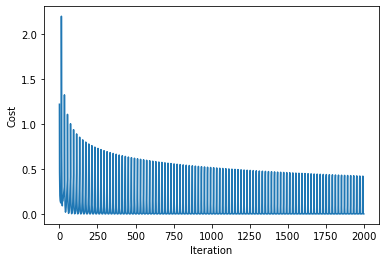

In [52]:
plt.plot(loss_values_conv)
plt.xlabel("Iteration")
plt.ylabel("Cost")

## Train a model using learning rate of 0.01, 120 epochs and batch_size of 1

<Figure size 432x288 with 0 Axes>

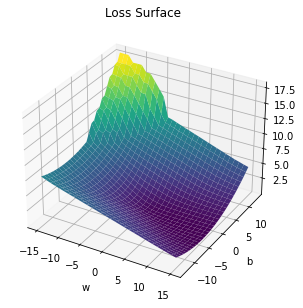

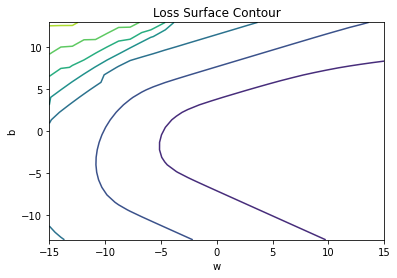

In [53]:
get_surface = plot_error_surfaces(15, 13, data_set[:][0], data_set[:][1], 30)

## Train the model

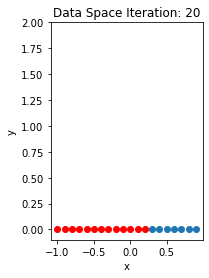

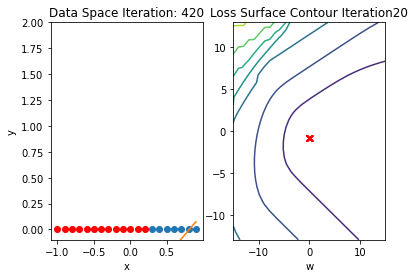

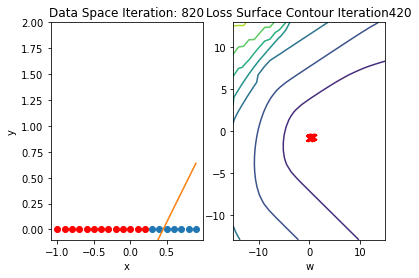

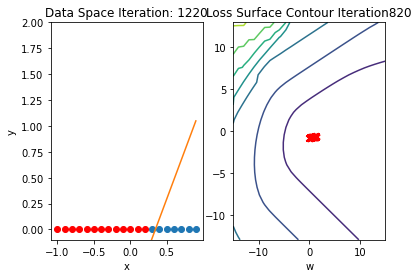

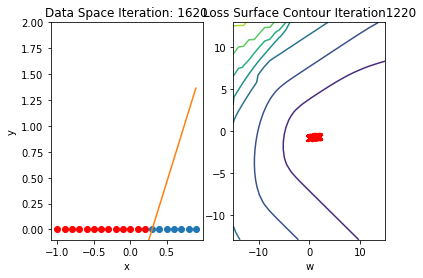

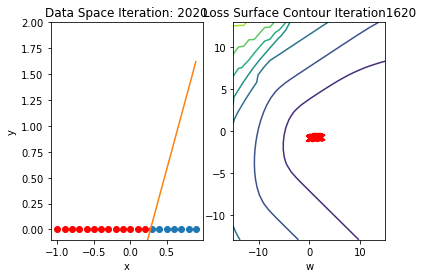

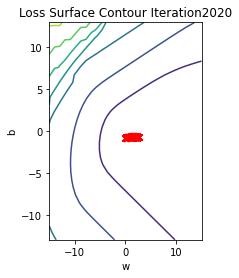

In [54]:
# First we create an instance of the model we want to train
model = logistic_regression(1)
# We create a criterion that will measure loss
criterion = nn.BCELoss()
# We create a data loader with the dataset and specified batch size of 1
trainloader = DataLoader(dataset = data_set, batch_size = 1)
# We create an optimizer with the model parameters and learning rate
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
# Then we set the number of epochs which is the total number of times we will train on the entire training dataset
epochs=120
# This will store the loss over iterations so we can plot it at the end
loss_values = []

# Loop will execute for number of epochs
for epoch in range(epochs):
    # For each batch in the training data
    for x, y in trainloader:
        # Make our predictions from the X values
        yhat = model(x)
        # Measure the loss between our prediction and actual Y values
        loss = criterion(yhat, y)
        # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
        optimizer.zero_grad()
        # Calculates the gradient value with respect to each weight and bias
        loss.backward()
        # Updates the weight and bias according to calculated gradient value
        optimizer.step()
        # Set the parameters for the loss surface contour graphs
        get_surface.set_para_loss(model, loss.tolist())
        # Saves the loss of the iteration
        loss_values.append(loss)
    # Want to print the Data Space for the current iteration every 20 epochs
    if epoch % 20 == 0:
        get_surface.plot_ps()

In [55]:
# final value of weight and bias
w = model.state_dict()['linear.weight'].data[0]
b = model.state_dict()['linear.bias'].data[0]
print("w = ", w, "b = ", b)

w =  tensor([2.8678]) b =  tensor(-0.7571)


In [56]:
# Getting the predictions
yhat = model(data_set.x)
# Rounding the prediction to the nearedt integer 0 or 1 representing the classes
yhat = torch.round(yhat)
# Counter to keep track of correct predictions
correct = 0
# Goes through each prediction and actual y value
for prediction, actual in zip(yhat, data_set.y):
    # Compares if the prediction and actualy y value are the same
    if (prediction == actual):
        # Adds to counter if prediction is correct
        correct+=1
# Outputs the accuracy by dividing the correct predictions by the length of the dataset
print("Accuracy: ", correct/len(data_set)*100, "%")

Accuracy:  100.0 %


In [57]:
loss_values_conv = []

for loss_v in loss_values:
    loss_values_conv.append(loss_v.detach().numpy())

Text(0, 0.5, 'Cost')

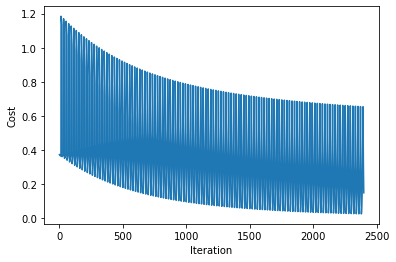

In [58]:
plt.plot(loss_values_conv)
plt.xlabel("Iteration")
plt.ylabel("Cost")